In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os,sys
import pylab as plt
%matplotlib inline

import glob


In [2]:
src_dir = '../src'
sys.path.append(src_dir)
from jsd import jsdalpha

In [3]:
src_meta = '../../gutenberg/src/'
sys.path.append(src_meta)
from metaquery import meta_query


In [4]:
# Load meta data

In [6]:
meta=meta_query(path=src_meta+'../metadata/metadata.csv')

# Most downloaded books (in english)

In [65]:
# meta.get_df()

In [66]:
list_authors = []
Smax = 10
nmin=20
S = 0

meta.reset()
meta.filter_lang('en',how='only')
meta.filter_downloads(-1)

for author in list(meta.get_df()['author']):
    meta.reset()
    meta.filter_lang('en',how='only')
    meta.filter_author(author)
    list_pg_tmp = meta.get_ids()
    n = len(list_pg_tmp)
    if n>=nmin and author not in list_authors:
        list_authors += [author]
        S+=1
        print(author,n)
    if S==Smax:
        break

Austen, Jane 22
Conrad, Joseph 69
Wilde, Oscar 41
Carroll, Lewis 28
Dickens, Charles 141
Twain, Mark 202
Melville, Herman 25
Stevenson, Robert Louis 90
Doyle, Arthur Conan 106
Tolstoy, Leo, graf 47


In [67]:
list_authors += ['All']
list_books = []

lang = 'en'
for author in list_authors:
    meta.reset()
    meta.filter_lang(lang,how='any')
    if author=='All':
        pass
    else:
        meta.filter_author(author)
    books_tmp = meta.get_ids()
    list_books += [books_tmp]

In [68]:
[len(h) for h in list_books]

[22, 69, 41, 28, 141, 202, 25, 90, 106, 47, 46477]

In [69]:
arr_alpha = np.array([0.0,1.0,2.0])
Npair = 100
weights = False ## standard 1/2,1.2
normalized = True ## 0<=divergence <=1

path_read = '../../gutenberg/data/counts/'

list_jsdalpha = []
list_labels = []
for i_s,s in enumerate(list_authors):
    print(s)
    list_jsd_tmp = []
    books_tmp=list_books[i_s]
    for i_Npair in range(Npair):
        
        book_sel = True
        while book_sel== True:

            pg1,pg2 = np.random.choice(books_tmp,replace=False,size=2)
            fname_read = '%s_counts.txt'%(pg1)
            filename1 = os.path.join(path_read,fname_read)

            fname_read = '%s_counts.txt'%(pg2)
            filename2 = os.path.join(path_read,fname_read)
            
            if os.path.isfile(filename1) and os.path.isfile(filename2):
                book_sel = False
        jsd = jsdalpha(filename1,filename2,alpha=arr_alpha,weights=weights,normalized=normalized)
        list_jsd_tmp += [jsd]
    list_jsdalpha += [list_jsd_tmp]

Austen, Jane
Conrad, Joseph
Wilde, Oscar
Carroll, Lewis
Dickens, Charles
Twain, Mark
Melville, Herman
Stevenson, Robert Louis
Doyle, Arthur Conan
Tolstoy, Leo, graf
All


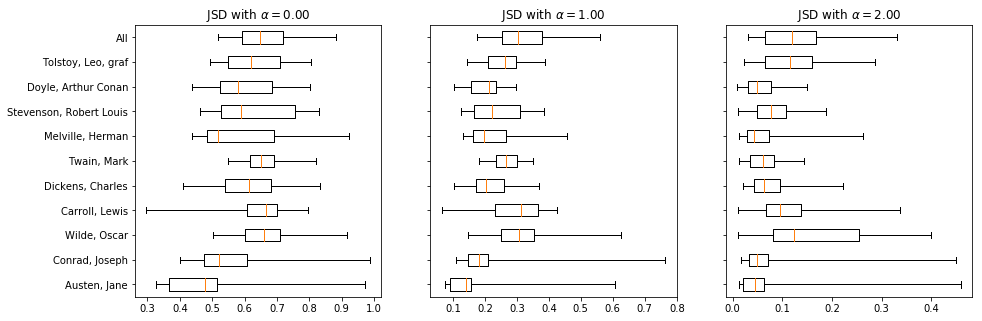

In [70]:
f=plt.figure(figsize = (15,5))
for i_alpha,alpha in enumerate(arr_alpha):
    ax=f.add_subplot(1,3,i_alpha+1)
    list_jsd_plot = [ [h[i_alpha] for h in jsd_tmp] for jsd_tmp in list_jsdalpha ]

    _ =ax.boxplot(list_jsd_plot,vert=False,whis=[2.5,97.5],labels=list_authors,sym='')
    _ = ax.set_title(r'JSD with $\alpha = %.2f$'%(alpha))
    
    if i_alpha>0:
        ax.set_yticklabels([])
#     ax.set_xlim(0,1)

## Compare authors pairwise

In [71]:
N_a = len(list_authors)

arr_alpha = np.array([0.0,1.0,2.0])
Npair = 100
weights = False ## standard 1/2,1.2
normalized = True ## 0<=divergence <=1

path_read = '../../gutenberg/data/counts/'

list_jsdalpha = []
list_labels = []

jsd_mu = np.zeros((N_a,N_a,len(arr_alpha)))
jsd_std = np.zeros((N_a,N_a,len(arr_alpha)))

for i_a1,a1 in enumerate(list_authors):
    for i_a2,a2 in enumerate(list_authors):
        if i_a1 < i_a2:
            mu=np.nan
            std=np.nan
        else:
            
#             print(t1,t2)
            books_tmp1=list_books[i_a1]
            books_tmp2=list_books[i_a2]
            list_jsd_tmp = []
            for i_Npair in range(Npair):

                book_sel = True
                while book_sel== True:

                    pg1 = np.random.choice(books_tmp1)#,replace=False,size=1)
                    pg2 = np.random.choice(books_tmp2)#,replace=False,size=1)
                    fname_read = '%s_counts.txt'%(pg1)
                    filename1 = os.path.join(path_read,fname_read)

                    fname_read = '%s_counts.txt'%(pg2)
                    filename2 = os.path.join(path_read,fname_read)

                    if os.path.isfile(filename1) and os.path.isfile(filename2):
                        book_sel = False
                jsd = jsdalpha(filename1,filename2,alpha=arr_alpha,weights=weights,normalized=normalized)
                list_jsd_tmp += [jsd]
                
            mu = [ np.mean( [h[i_alpha] for h in list_jsd_tmp]) for i_alpha,alpha in enumerate(arr_alpha)]
            std = [ np.std( [h[i_alpha] for h in list_jsd_tmp]) for i_alpha,alpha in enumerate(arr_alpha)]
        jsd_mu[i_a1,i_a2,:] = mu
        jsd_std[i_a1,i_a2,:] = std

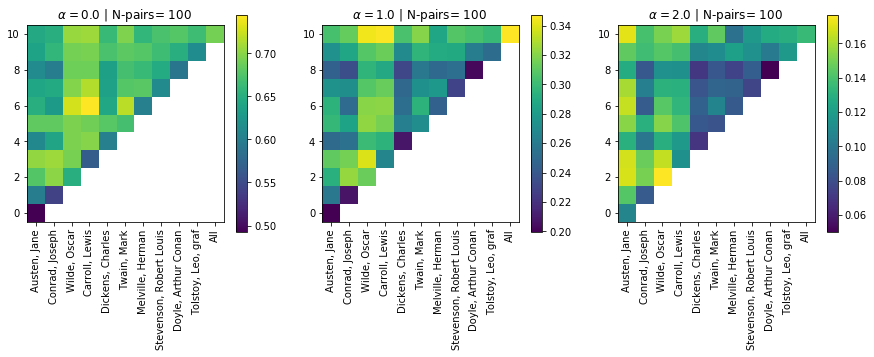

In [72]:
fig=plt.figure(figsize=(15,4))
for i_alpha,alpha in enumerate(arr_alpha):
    ax=fig.add_subplot(1,3,i_alpha+1)
    Z = jsd_mu[:,:,i_alpha]
    im=ax.imshow(Z,origin='lower')
    cbar = fig.colorbar(im)
    ax.set_xticks(np.arange(N_a))
    ax.set_xticklabels(list_authors,rotation=90)
#     ax.set_yticks(np.arange(N_a))
#     ax.set_yticklabels(list_authors,rotation=0)
    ax.set_title(r' $\alpha=%s$ | N-pairs= %s  '%(alpha,Npair))
#     plt.colorbar()